# <center>Qubit demos - working with a real qubit

Here we make the demos to work with a real qubit. This noteboook uses the tproc v2 version of teh firmware and the zcu216 board.


Imports

In [376]:
# jupyter setup boilerplate
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from qick import *

# for now, all the tProc v2 classes need to be individually imported (can't use qick.*)

# the main program class
from qick.asm_v2 import AveragerProgramV2
# for defining sweeps
from qick.asm_v2 import QickSpan, QickSweep1D

from fitting import *

No module named 'visa'
Warning VISA library import failed
Warning serial library import failed.
Could not load InstrumentManagerWindow


Connect to RFSoC using Pyro4

In [2]:
import Pyro4
from qick import QickConfig
Pyro4.config.SERIALIZER = "pickle"
Pyro4.config.PICKLE_PROTOCOL_VERSION=4

ns_host = "192.168.1.144"
ns_port = 8000
proxy_name = "rfsoc"

ns = Pyro4.locateNS(host=ns_host, port=ns_port)
soc = Pyro4.Proxy(ns.lookup(proxy_name))
soccfg = QickConfig(soc.get_cfg())
print(soccfg)

QICK running on ZCU216, software version 0.2.280

Firmware configuration (built Thu May 30 14:53:02 2024):

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	12 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 32768 samples (4.762 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 32-bit DDS, range=6881.280 MHz
		DAC tile 2, blk 0 is 0_230, on JHC3
	1:	axis_signal_gen_v6 - envelope memory 32768 samples (4.762 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 32-bit DDS, range=6881.280 MHz
		DAC tile 2, blk 1 is 1_230, on JHC4
	2:	axis_signal_gen_v6 - envelope memory 32768 samples (4.762 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 32-bit DDS, range=6881.280 MHz
		DAC tile 2, blk 2 is 2_230, on JHC3
	3:	axis_signal_gen_v6 - envelope memory 32768 samples (4.762 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 32-bit DDS, range=6881.280 MHz
		DAC tile 2, blk 3 is 3_230, on JHC4
	4:	axis_signal_gen_v6 - envelope memory 32768 samples (13.333 us)
		fs=2457.600 MHz, fabric=153.600 

### Helper functions

In [3]:
#Figure params
# rcParams['figure.figsize'] = 16, 8
# rcParams.update({'font.size': 22})

#helper functions
def hist(data=None, plot=True, ran=1.0):
    
    ig = data[0]
    qg = data[1]
    ie = data[2]
    qe = data[3]

    numbins = 200
    
    xg, yg = np.median(ig), np.median(qg)
    xe, ye = np.median(ie), np.median(qe)

    if plot==True:
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
        fig.tight_layout()

        axs[0].scatter(ig, qg, label='g', color='b', marker='*')
        axs[0].scatter(ie, qe, label='e', color='r', marker='*')
        axs[0].scatter(xg, yg, color='k', marker='o')
        axs[0].scatter(xe, ye, color='k', marker='o')
        axs[0].set_xlabel('I (a.u.)')
        axs[0].set_ylabel('Q (a.u.)')
        axs[0].legend(loc='upper right')
        axs[0].set_title('Unrotated')
        axs[0].axis('equal')
    """Compute the rotation angle"""
    theta = -np.arctan2((ye-yg),(xe-xg))
    """Rotate the IQ data"""
    ig_new = ig*np.cos(theta) - qg*np.sin(theta)
    qg_new = ig*np.sin(theta) + qg*np.cos(theta) 
    ie_new = ie*np.cos(theta) - qe*np.sin(theta)
    qe_new = ie*np.sin(theta) + qe*np.cos(theta)
    
    """New means of each blob"""
    xg, yg = np.median(ig_new), np.median(qg_new)
    xe, ye = np.median(ie_new), np.median(qe_new)
    
    #print(xg, xe)
    
    xlims = [xg-ran, xg+ran]
    ylims = [yg-ran, yg+ran]

    if plot==True:
        axs[1].scatter(ig_new, qg_new, label='g', color='b', marker='*')
        axs[1].scatter(ie_new, qe_new, label='e', color='r', marker='*')
        axs[1].scatter(xg, yg, color='k', marker='o')
        axs[1].scatter(xe, ye, color='k', marker='o')    
        axs[1].set_xlabel('I (a.u.)')
        axs[1].legend(loc='lower right')
        axs[1].set_title('Rotated')
        axs[1].axis('equal')

        """X and Y ranges for histogram"""
        
        ng, binsg, pg = axs[2].hist(ig_new, bins=numbins, range = xlims, color='b', label='g', alpha=0.5)
        ne, binse, pe = axs[2].hist(ie_new, bins=numbins, range = xlims, color='r', label='e', alpha=0.5)
        axs[2].set_xlabel('I(a.u.)')       
        
    else:        
        ng, binsg = np.histogram(ig_new, bins=numbins, range = xlims)
        ne, binse = np.histogram(ie_new, bins=numbins, range = xlims)

    """Compute the fidelity using overlap of the histograms"""
    contrast = np.abs(((np.cumsum(ng) - np.cumsum(ne)) / (0.5*ng.sum() + 0.5*ne.sum())))
    tind=contrast.argmax()
    threshold=binsg[tind]
    fid = contrast[tind]
    axs[2].set_title(f"Fidelity = {fid*100:.2f}%")

    return fid, threshold, theta

### Configuring the channels

In [4]:
# DAC Signal Generating Channels
GEN_CH0 = 0
GEN_CH1 = 1
GEN_CH2 = 2
GEN_CH3 = 3
GEN_CH4 = 4
GEN_CH5 = 5
GEN_CH6 = 6
GEN_CH7 = 7
GEN_CH8 = 8
GEN_CH9 = 9
GEN_CH10 = 10
GEN_CH11 = 11

# ADC Readout Channels
RO_CH0 = 0
RO_CH1 = 1
RO_CH2 = 2
RO_CH3 = 3
RO_CH4 = 4
RO_CH5 = 5

# TOF Measurement

Measures the "time of flight" of the measurement pulse. The time of flight is the time at which the measurement pulse appears in the ADC buffer. We only want to start capturing data from this point in time onwards. We store this time of flight in the parameter <code> config["trig_time"] </code>.

In [1054]:
##################
# Define Program #
##################

class LoopbackProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=2)
        # pynq configured
        # self.declare_readout(ch=ro_ch, length=cfg['ro_len'], freq=cfg['freq'], gen_ch=gen_ch)
        
        # tproc configured
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])
        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['freq'], gen_ch=gen_ch)

        self.add_pulse(ch=gen_ch, name="myconst", ro_ch=ro_ch, 
                       style="const", 
                       length=cfg['pulse_len'], 
                       freq=cfg['freq'], 
                       phase=cfg['pulse_phase'],
                       gain=cfg['pulse_gain'],
                      )
    
    def _body(self, cfg):
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        self.pulse(ch=cfg['gen_ch'], name="myconst", t=0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=0, ddr4=True)

config = {
    ## Channel Params. ##
    'gen_ch': GEN_CH6,
    'ro_ch': RO_CH1,
    ## Pulse Params. ##
    'freq': 7100, # [MHz]
    'pulse_len': 0.5, # [us]
    'pulse_phase': 0, # [deg]
    'pulse_gain': 0.8, # [DAC units]
    ## Readout Params. ##
    'trig_time': 0.0, # [us]
    'ro_len': 1.6, # [us]
     }

###################
# Run the Program
###################

prog =LoopbackProgram(soccfg, reps=1, final_delay=0.5, cfg=config)
iq_list = prog.acquire_decimated(soc, soft_avgs=1000)
t = prog.get_time_axis(ro_index=0)

  0%|          | 0/1000 [00:00<?, ?it/s]

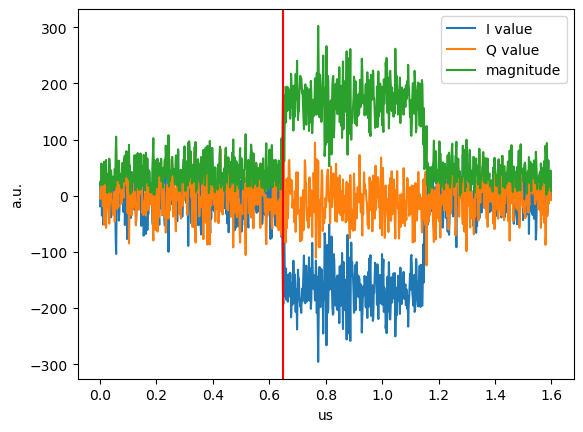

In [1055]:
# Plot results.
plt.plot(t, iq_list[0][:,0], label="I value")
plt.plot(t, iq_list[0][:,1], label="Q value")
plt.plot(t, np.abs(iq_list[0].dot([1,1j])), label="magnitude")
plt.legend()
plt.ylabel("a.u.")
plt.xlabel("us");

######## SET THIS VALUE AS YOUR config['trig_time'] #########
plt.axvline(0.65, c='r') 

# Single tone (Resonator) Spectroscopy

Measures the resonant frequency of the readout resonator when the qubit is in its ground state. We store this resonant frequency in the parameter <code> config["f_res"] </code>.

In [1056]:
## Using the Dynamically Configured Readout Channel ##
class SingleToneSpectroscopyProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        res_ch = cfg['res_ch']
        
        self.declare_gen(ch=res_ch, nqz=2)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])

        self.add_loop("freqloop", cfg["steps"])
        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['f_res'], gen_ch=res_ch)
        
        self.add_pulse(ch=res_ch, name="res_pulse", ro_ch=ro_ch, 
                       style="const", 
                       length=cfg['res_len'], 
                       freq=cfg['f_res'], 
                       phase=cfg['res_phase'],
                       gain=cfg['res_gain'],
                      )
        
    def _body(self, cfg):
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        self.pulse(ch=cfg['res_ch'], name="res_pulse", t=0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])

In [1057]:
START_FREQ = 7147 # [MHz]
STOP_FREQ = 7152 # [MHz]
STEPS = 1000

config = {
    ## Sweep Params: ##
    'steps': STEPS, # Number of sweep points
    
    ## Channel Params. ##
    'res_ch': GEN_CH6,
    'ro_ch': RO_CH1,

    ## Resonator Pulse Params. ##
    'f_res': QickSweep1D('freqloop', START_FREQ, STOP_FREQ), # [MHz]
    'res_len': 1.0, # [us]
    'res_phase': 0, # [deg]
    'res_gain': 0.3, # [DAC units]

    ## Readout Params. ##
    'trig_time': 0.65, # [us]
    'ro_len': 10.0, # [us]
    'relax_delay': 1000, # [us]
     }

prog = SingleToneSpectroscopyProgram(soccfg, reps=10000, final_delay=0.5, cfg=config)

iq_list = prog.acquire(soc, soft_avgs=1, progress=True)
freqs = prog.get_pulse_param("res_pulse", "freq", as_array=True)

  0%|          | 0/10000000 [00:00<?, ?it/s]

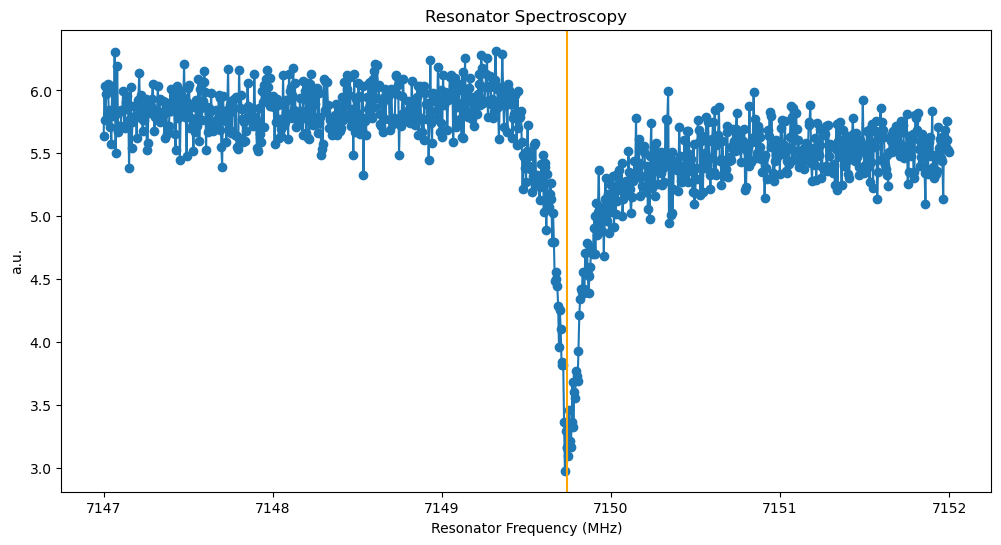

In [1058]:
plt.figure(figsize=(12,6))
plt.plot(freqs, np.abs(iq_list[0][0].dot([1,1j])), marker='o')
plt.ylabel("a.u.")
plt.xlabel("Resonator Frequency (MHz)")
plt.title('Resonator Spectroscopy')
# plt.xlim(7146, 7148)
plt.axvline(7149.741691528487, c='orange') # The frequency that you will put into config['f_res']

- - - Fit Results - - - 
Resonator Frequency (MHz): 7149.7219510907225
Linewidth (MHz): 0.18646481974247733
- - - - - - - - - - - -


c:\Users\G41Lab\anaconda3\malab\dsfit.py:363: RuntimeWarning: invalid value encountered in log10
  y = 10 * np.log10(scale * (Qc ** 2. + Qi ** 2. * Qc ** 2. * (2. * a + b) ** 2.) / (


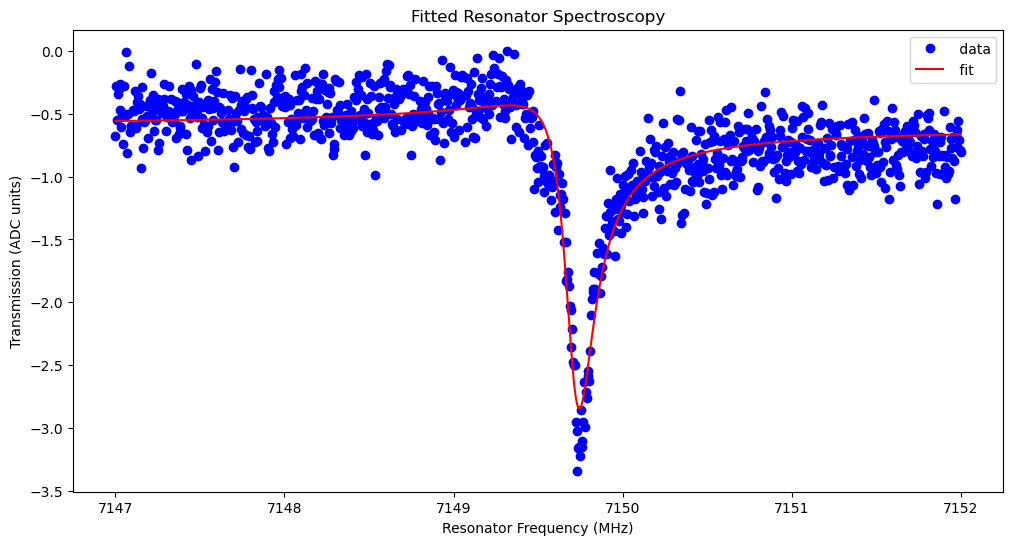

In [1059]:
Qi=[]
Qc=[]
fs=[]
Linewidth=[]
plt.figure(figsize=(12,6))
plt.ylabel("Transmission (ADC units)")
plt.xlabel("Resonator Frequency (MHz)")
plt.title('Fitted Resonator Spectroscopy')
amps =  np.abs(iq_list[0][0].dot([1,1j]))
fits = fithanger_new_withQc(freqs,amps-max(amps),
                            showfit=True,showstartfit=False,printresult=False)
Linewidth.append(fits[0]/fits[1])
Qi.append(fits[1])
Qc.append(fits[2])
fs.append(fits[0])
print('- - - Fit Results - - - ')
print('Resonator Frequency (MHz):', fs[0])
print('Linewidth (MHz):', Linewidth[0])
print('- - - - - - - - - - - -')
plt.legend()


# Pulse Probe (qubit) spectroscopy

Measures the qubit frequency f_ge. We store this parameter here: <code> exp_config["f_ge"] </code>.

In [1060]:
class PulseProbeSpectroscopyProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        res_ch = cfg['res_ch']
        qubit_ch = cfg['qubit_ch']
        
        self.declare_gen(ch=res_ch, nqz=2)
        self.declare_gen(ch=qubit_ch, nqz=1)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])

        self.add_loop("freqloop", cfg["steps"])
        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['f_res'], gen_ch=res_ch)
        
        self.add_pulse(ch=res_ch, name="res_pulse", ro_ch=ro_ch, 
                       style="const", 
                       length=cfg['res_len'], 
                       freq=cfg['f_res'], 
                       phase=cfg['res_phase'],
                       gain=cfg['res_gain'],
                      )
        
        self.add_pulse(ch=qubit_ch, name="qubit_pulse", ro_ch=ro_ch, 
                       style="const", 
                       length=cfg['probe_len'], 
                       freq=cfg['f_ge'], 
                       phase= 0,
                       gain=cfg['qubit_gain'],
                      )
    
    def _body(self, cfg):
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        self.pulse(ch=self.cfg["qubit_ch"], name="qubit_pulse", t=0)  #play probe pulse

        self.pulse(ch=cfg['res_ch'], name="res_pulse", t=0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])

        self.wait_auto(cfg['relax_delay']) # wait for qubit to relax


In [1061]:
START_FREQ = 2920 # [MHz]
STOP_FREQ = 3000 # [MHz]
STEPS = 1000

config = {
    ## Sweep Params: ##
    'steps': STEPS, # Number of sweep points

    ## Channel Params. ##
    'res_ch': GEN_CH6,
    'ro_ch': RO_CH1,
    'qubit_ch': GEN_CH4,
    
    ## Resonator Pulse Params. ##
    'f_res': 7149.72, # [MHz]
    'res_len': 2.0, # [us]
    'res_phase': 0, # [deg]
    'res_gain': 0.3, # [DAC units]

    ## Readout Params. ##
    'trig_time': 0.65, # [us]
    'ro_len': 10.0, # [us]
    'relax_delay': 1000, # [us]
    
    ## Qubit Params. ##
    'f_ge': QickSweep1D('freqloop', START_FREQ, STOP_FREQ), # [MHz]
    "probe_len": 10.0, # [us]
    "qubit_gain": 0.2, # [DAC units]
     }

qspec=PulseProbeSpectroscopyProgram(soccfg, reps=100, final_delay=0.5, cfg=config)
iq_list = qspec.acquire(soc, soft_avgs=100, progress=True)
freqs = qspec.get_pulse_param('qubit_pulse', "freq", as_array=True)

  0%|          | 0/100 [00:00<?, ?it/s]

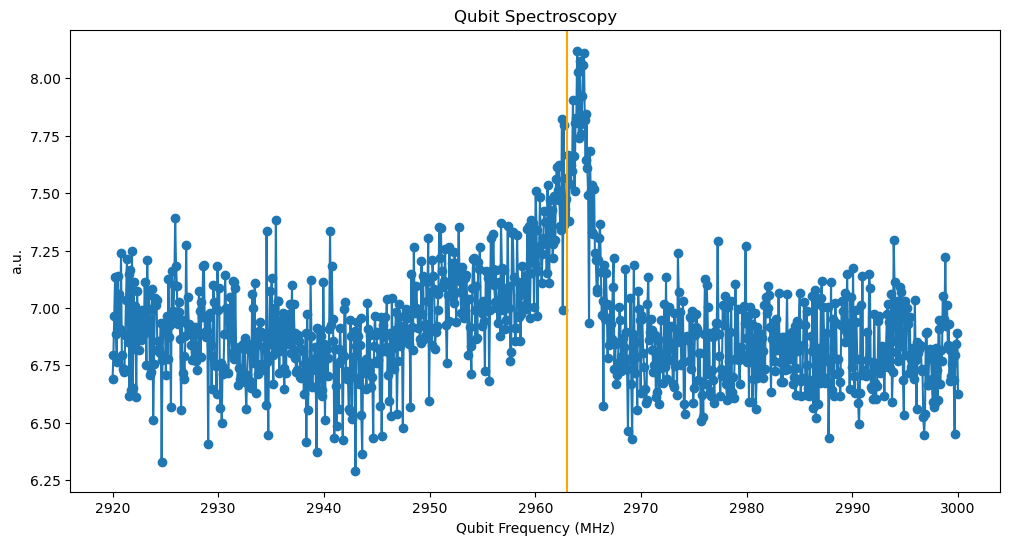

In [1064]:
plt.figure(figsize=(12,6))
plt.subplot(111,title="Qubit Spectroscopy", xlabel="Qubit Frequency (MHz)", ylabel="a.u.")
plt.plot(freqs, np.abs(iq_list[0][0].dot([1,1j])),'o-')
plt.axvline(2963, c='orange'); # The qubit frequency that will be set in config['f_ge']

Qubit Frequency (MHz): 2963.492599909607


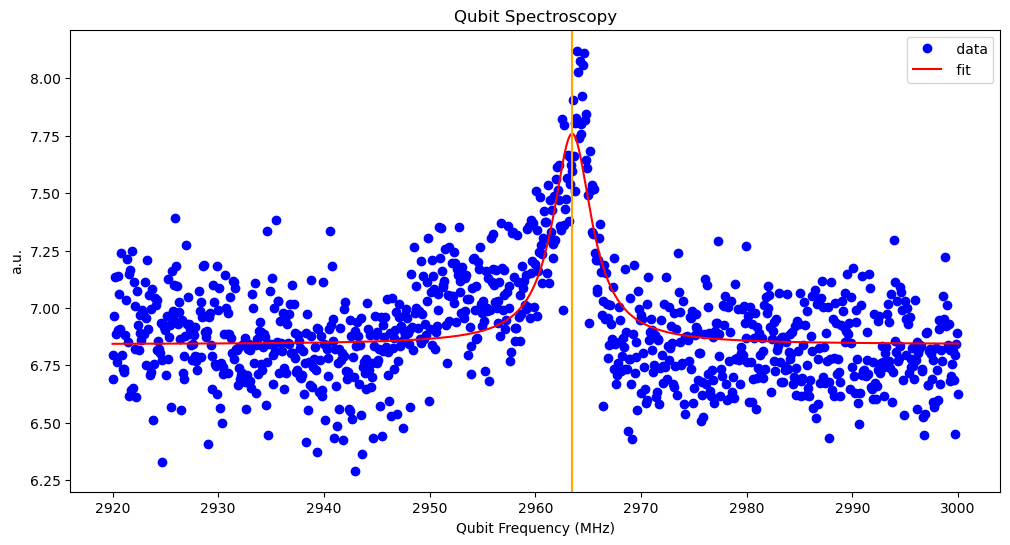

In [1065]:
amps = np.abs(iq_list[0][0].dot([1,1j]))

plt.figure(figsize=(12,6))
plt.subplot(111,title="Qubit Spectroscopy", xlabel="Qubit Frequency (MHz)", ylabel="a.u.")
f_q = fitlor(freqs, amps, showfit = True)[2]
print('Qubit Frequency (MHz):', f_q)
plt.axvline(f_q, c='orange'); # The qubit frequency that will be set in config['f_ge']
plt.legend()

# Length Rabi

Measures Rabi oscillations by sweeping over the duration of the qubit drive pulse. This is a preliminary measurement to prove that we see Rabi oscillations. This measurement is followed up by the Amplitude Rabi experiment below.

In [976]:
class LengthRabiProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        res_ch = cfg['res_ch']
        qubit_ch = cfg['qubit_ch']
        
        self.declare_gen(ch=res_ch, nqz=2)
        self.declare_gen(ch=qubit_ch, nqz=1)
        # pynq configured
        # self.declare_readout(ch=ro_ch, length=cfg['ro_len'], freq=cfg['f_res'], gen_ch=res_ch)
        
        # tproc configured
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])
        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['f_res'], gen_ch=res_ch)


        # self.add_loop("lenloop", cfg["steps"])
        
        self.add_pulse(ch=res_ch, name="res_pulse", ro_ch=ro_ch, 
                       style="const", 
                       length=cfg['res_len'], 
                       freq=cfg['f_res'], 
                       phase=cfg['res_phase'],
                       gain=cfg['res_gain'],
                      )
        
        self.add_pulse(ch=qubit_ch, name="qubit_pulse", ro_ch=ro_ch, 
                       style="const", 
                       length=cfg['probe_len'], 
                       freq=cfg['f_ge'], 
                       phase= cfg['qubit_phase'],
                       gain=cfg['qubit_gain'],
                      )
        # self.delay_auto()
        

    # def _body(self, cfg):
    #     self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
    #     self.pulse(ch=cfg["qubit_ch"], name="qubit_pulse", t=0)  #play probe pulse

    #     # These are equivilent - all pause the tproc which pauses execution of commands
    #     ### These all set the time between the two pulses always to the max qubit pulse length because they only accept constant integer values
    #     # self.wait_auto(t=0, gens=True, tag='waiting')
    #     # self.wait(t=cfg['probe_len'])
    #     # self.wait_auto(t=self.cfg['probe_len'], tag='waiting')

    #     # These are equivilant along with changing the pulse time - increment the master time (pushing back all commands by time t)
    #     # self.delay(t=cfg['probe_len'], tag='waiting')
    #     self.delay_auto(t=0.1, tag='waiting')
    #     # self.pulse(ch=cfg['res_ch'], name="res_pulse", t=cfg['probe_len'], tag='waiting')
        
    #     self.pulse(ch=cfg['res_ch'], name="res_pulse", t=0)
    #     self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])
        

    def _body(self, cfg):
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        self.pulse(ch=cfg["qubit_ch"], name="qubit_pulse", t=0)  #play probe pulse

        self.delay_auto(t=0.0, tag='waiting')
        
        self.pulse(ch=cfg['res_ch'], name="res_pulse", t=0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])


In [889]:
tproc_cc = (1.0 / (430.080*10**6))*10**6 # [us]
gen_cc = (1.0 / (245.760*10**6))*10**6 # [us]

print(tproc_cc)
print(gen_cc)

0.0023251488095238095
0.004069010416666667


In [1077]:

# tproc channel
START_LEN = tproc_cc*20 # [us]
STOP_LEN = tproc_cc*200 # [us]
STEPS = 45

# generator channel
# START_LEN = gen_cc*20 # [us]
# STOP_LEN = gen_cc*200 # [us]
# STEPS = 45

# START_LEN = 0.02 # [us]
# STOP_LEN = 5 # [us]
# STEPS = 100

config = {
    ## Sweep Params: ##
    'steps': STEPS, # Number of sweep points

    ## Channel Params. ##
    'res_ch': GEN_CH6,
    'ro_ch': RO_CH1,
    'qubit_ch': GEN_CH4,
    
    ## Resonator Pulse Params. ##
    'f_res': 7149.742, # [MHz]
    'res_len': 2.0, # [us]
    'res_phase': 0, # [deg]
    'res_gain': 0.5, # [DAC units]

    ## Readout Params. ##
    'trig_time': 0.65, # [us]
    'ro_len': 10.0, # [us]
    'relax_delay': 1000, # [us]
    
    ## Qubit Params. ##
    'f_ge': 2963.49, # [MHz]
    "probe_len": 0.05,# QickSweep1D('lenloop', START_LEN, STOP_LEN), # [us]
    'qubit_phase': 0, # [deg]
    "qubit_gain":0.2, # [DAC units]
     }


expt_cfg={
        "start":0.05, "step":0.05, "expts":200, "reps": 1,
       }
cfg={**config, **expt_cfg} #combine configs
expt_pts=[expt_cfg["start"] + ii*expt_cfg["step"] for ii in range(expt_cfg["expts"])]

results=[]
i = 0
for length in expt_pts:
    config["probe_len"]=length

    rabi=LengthRabiProgram(soccfg,
                         reps=cfg['reps'],
                         final_delay=config['relax_delay'],
                         final_wait=1000.0,
                         cfg=cfg)
    data = rabi.acquire(soc, soft_avgs = 10, progress=False)
    results.append(data[0][0])
    print(i)
    i+=1

# prog = LengthRabiProgram(soccfg,
#                          reps=1,
#                          final_delay=config['relax_delay'],
#                          final_wait=1000.0,
#                          cfg=config)

# iq_list = prog.acquire(soc, soft_avgs=10)
# t = prog.get_pulse_param('qubit_pulse', "length", as_array=True)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68


In [1076]:
np.shape(results)

(200, 45, 2)

ValueError: x and y must have same first dimension, but have shapes (200,) and (2,)

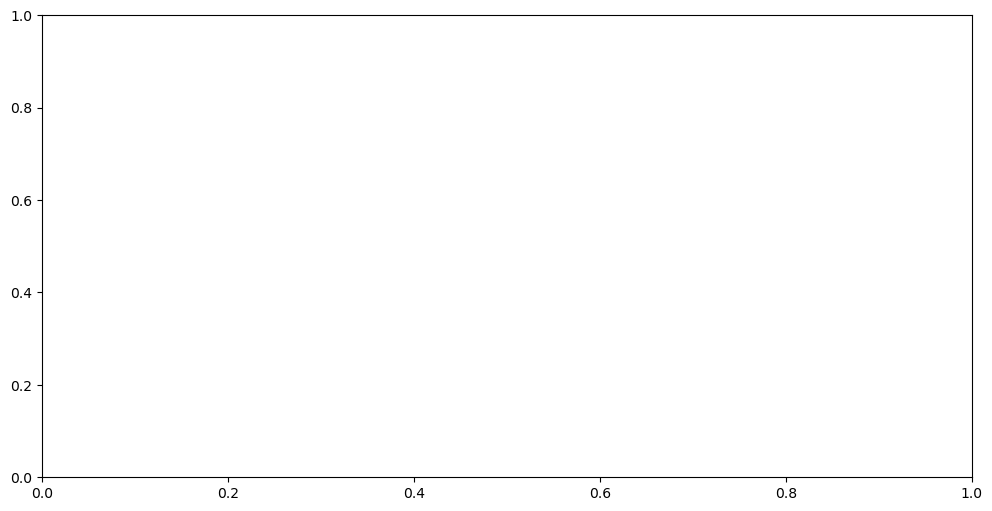

In [1073]:
plt.figure(figsize=(12,6))
plt.plot(expt_pts, np.abs(results[0][0]),'o-')
plt.ylabel("a.u.")
plt.xlabel(r"Pulse Length ($\mu s$)")
plt.title('Length Rabi')

plt.axvline(1, c='orange'); # The pi pulse length that will be set in config['probe_length']

In [1017]:
actual_times = np.empty(STEPS)
step_size = (STOP_LEN - START_LEN) / STEPS

for i in range(0, STEPS):
    actual_times[i] = START_LEN + step_size*i

print(actual_times)

[0.04650298 0.05580357 0.06510417 0.07440476 0.08370536 0.09300595
 0.10230655 0.11160714 0.12090774 0.13020833 0.13950893 0.14880952
 0.15811012 0.16741071 0.17671131 0.1860119  0.1953125  0.2046131
 0.21391369 0.22321429 0.23251488 0.24181548 0.25111607 0.26041667
 0.26971726 0.27901786 0.28831845 0.29761905 0.30691964 0.31622024
 0.32552083 0.33482143 0.34412202 0.35342262 0.36272321 0.37202381
 0.3813244  0.390625   0.3999256  0.40922619 0.41852679 0.42782738
 0.43712798 0.44642857 0.45572917]


In [1018]:
0.45572917 / tproc_cc

196.0000014336

In [1011]:
t_waiting = prog.get_time_param('waiting', 't', as_array=True)
print(t_waiting)

[0.08370536 0.0953311  0.10695685 0.11858259 0.13020833 0.14183408
 0.15345982 0.16508557 0.17671131 0.18833705 0.1999628  0.21158854
 0.22321429 0.23484003 0.24646577 0.25809152 0.26971726 0.28134301
 0.29296875 0.30459449 0.31622024 0.32784598 0.33947173 0.35109747
 0.36272321 0.37434896 0.3859747  0.39760045 0.40922619 0.42085193
 0.43247768 0.44410342 0.45572917 0.46735491 0.47898065 0.4906064
 0.50223214 0.51385789 0.52548363 0.53710938 0.54873512 0.56036086
 0.57198661 0.58361235 0.5952381 ]


In [1012]:
0.5952381/tproc_cc

256.000002048

In [1013]:
t = prog.get_pulse_param('qubit_pulse', "length", as_array=True)
print(t)

[0.08463542 0.09765625 0.11067708 0.12369792 0.13671875 0.14973958
 0.16276042 0.17578125 0.18880208 0.20182292 0.21484375 0.22786458
 0.24088542 0.25390625 0.26692708 0.27994792 0.29296875 0.30598958
 0.31901042 0.33203125 0.34505208 0.35807292 0.37109375 0.38411458
 0.39713542 0.41015625 0.42317708 0.43619792 0.44921875 0.46223958
 0.47526042 0.48828125 0.50130208 0.51432292 0.52734375 0.54036458
 0.55338542 0.56640625 0.57942708 0.59244792 0.60546875 0.61848958
 0.63151042 0.64453125 0.65755208]


In [1003]:
(1.0 / (6881.280*10**6))*10**6 # [us]

0.0001453218005952381

In [1014]:
0.65755208/gen_cc

161.59999918079998

In [960]:
# using gen clock for steps
0.65755208/gen_cc

161.59999918079998

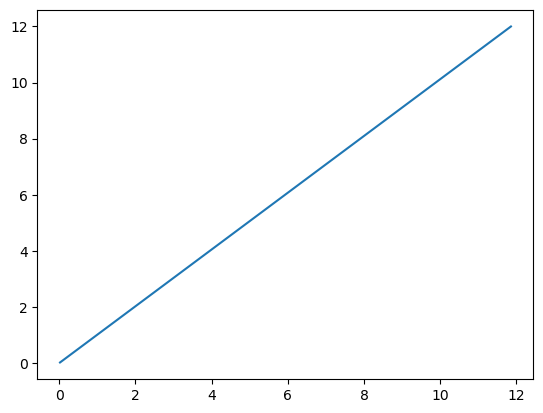

In [848]:
plt.plot(array(t),array(t_waiting))

In [823]:
1/0.67708333

1.4769230841940828

In [825]:
13.33/32768 * 1000

0.40679931640625

In [733]:
1.97916667 - 1.42066592

0.5585007499999999

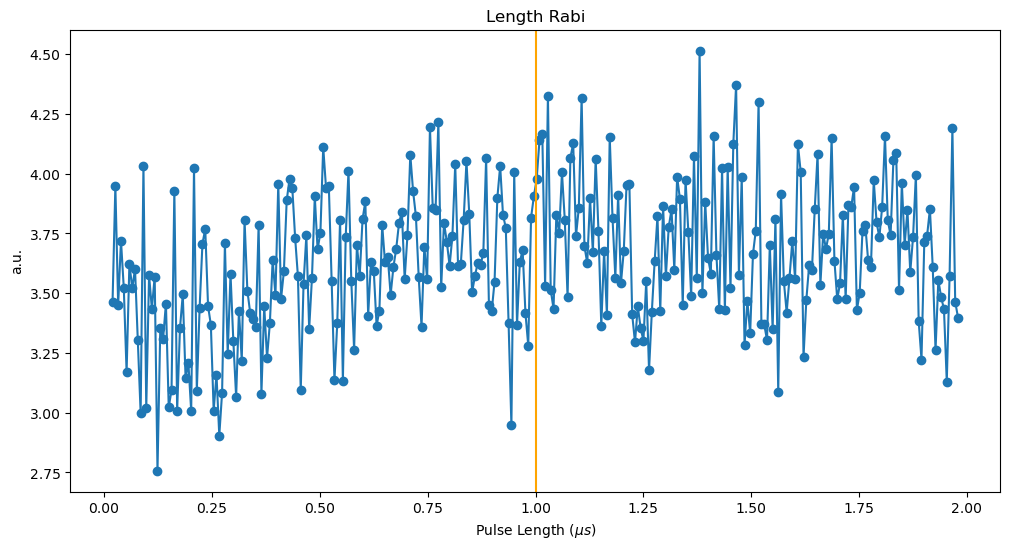

In [485]:
plt.figure(figsize=(12,6))
plt.plot(t, np.abs(iq_list[0][0].dot([1,1j])),'o-')
plt.ylabel("a.u.")
plt.xlabel(r"Pulse Length ($\mu s$)")
plt.title('Length Rabi')

plt.axvline(1, c='orange'); # The pi pulse length that will be set in config['probe_length']

In [ ]:
len_rabi=LengthRabiProgram(soccfg, reps=100, final_delay=0.5, cfg=config)
iq_list = len_rabi.acquire(soc, soft_avgs=10, progress=True)
times = len_rabi.get_pulse_param('qubit_pulse', "length", as_array=True)

plt.subplot(111,title="Length Rabi Oscillations", xlabel="Pulse Length (us)", ylabel="Qubit Population")
plt.plot(times, np.abs(iq_list[0][0].dot([1,1j])),'o-')

# Amplitude Rabi

Measures Rabi oscillations by sweeping over the amplitude of the qubit drive pulse, which is an $\approx$ 100 ns ($\sigma$ $\approx$ 25 ns) long Gaussian pulse. We measure the $\pi$ and $\pi$/2 pulse amplitudes which are used in subsequent experiments to control the qubit. We store these parameters here: <code> config["pi_gain"] </code> and <code> config["pi2_gain"] </code>

In [436]:
class AmplitudeRabiProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        res_ch = cfg['res_ch']
        qubit_ch = cfg['qubit_ch']
        
        self.declare_gen(ch=res_ch, nqz=2)
        self.declare_gen(ch=qubit_ch, nqz=1)
        # pynq configured
        # self.declare_readout(ch=ro_ch, length=cfg['ro_len'], freq=cfg['f_res'], gen_ch=res_ch)
        
        # tproc configured
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])
        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['f_res'], gen_ch=res_ch)

        self.add_loop("gainloop", cfg["steps"])
        
        self.add_pulse(ch=res_ch, name="res_pulse", ro_ch=ro_ch, 
                       style="const", 
                       length=cfg['res_len'], 
                       freq=cfg['f_res'], 
                       phase=cfg['res_phase'],
                       gain=cfg['res_gain'],
                      )
        
        self.add_gauss(ch=qubit_ch, name="ramp", sigma=cfg['sigma'], length=cfg['sigma']*4, even_length=True)
        self.add_pulse(ch=qubit_ch, name="qubit_pulse", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="ramp", 
                       freq=cfg['f_ge'], 
                       phase=cfg['qubit_phase'],
                       gain=cfg['qubit_gain'], 
                      )
    
    def _body(self, cfg):
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        self.pulse(ch=self.cfg["qubit_ch"], name="qubit_pulse", t=0)  #play probe pulse
        self.delay_auto()
        self.pulse(ch=cfg['res_ch'], name="res_pulse", t=0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])

        self.wait_auto(cfg['relax_delay']) # wait for qubit to relax


In [438]:
START_GAIN = 0.0 # [DAC units]
STOP_GAIN = 1.0 # [DAC units]
STEPS = 200

config = {
    ## Sweep Params: ##
    'steps': STEPS, # Number of sweep points

    ## Channel Params. ##
    'res_ch': GEN_CH6,
    'ro_ch': RO_CH1,
    'qubit_ch': GEN_CH4,
    
    ## Resonator Pulse Params. ##
    'f_res': 7149.742, # [MHz]
    'res_len': 1.0, # [us]
    'res_phase': 0, # [deg]
    'res_gain': 0.3, # [DAC units]

    ## Readout Params. ##
    'trig_time': 0.65, # [us]
    'ro_len': 10.0, # [us]
    'relax_delay': 1000, # [us]
    
    ## Qubit Params. ##
    'f_ge': 2962.21, # [MHz]
    "probe_len": 0.75, # [us]
    'qubit_phase': 0, # [deg]
    "qubit_gain":QickSweep1D('gainloop', START_GAIN, STOP_GAIN), # [DAC units]
    'sigma': 0.025,
     }

amp_rabi=AmplitudeRabiProgram(soccfg, reps=100, final_delay=0.5, cfg=config)
iq_list = amp_rabi.acquire(soc, soft_avgs=100, progress=True)
gains = amp_rabi.get_pulse_param('qubit_pulse', "gain", as_array=True)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

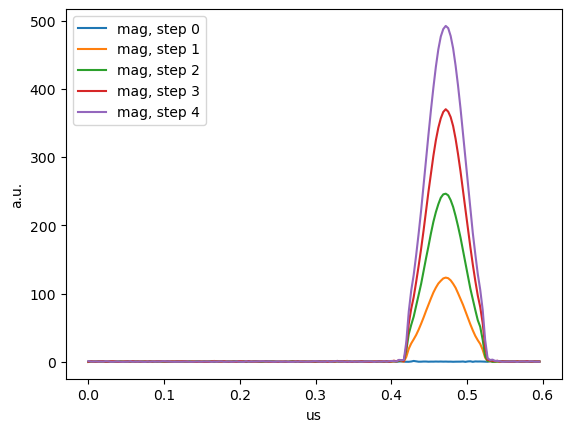

In [21]:
# Test to see if we set up gain sweep correctly (note: only do 5 steps, do a loopback type experiment)
prog = AmplitudeRabiProgram(soccfg, reps=1, final_delay=0.5, cfg=config)
iq_list = prog.acquire_decimated(soc, soft_avgs=10)
t = prog.get_time_axis(ro_index=0)

plt.figure(1)
for ii, iq in enumerate(iq_list[0]):
    # plt.plot(t, iq[:,0], label="I value, step %d"%(ii))
    # plt.plot(t, iq[:,1], label="Q value, step %d"%(ii))
    plt.plot(t, np.abs(iq.dot([1,1j])), label="mag, step %d"%(ii))

plt.legend()
plt.ylabel("a.u.")
plt.xlabel("us");

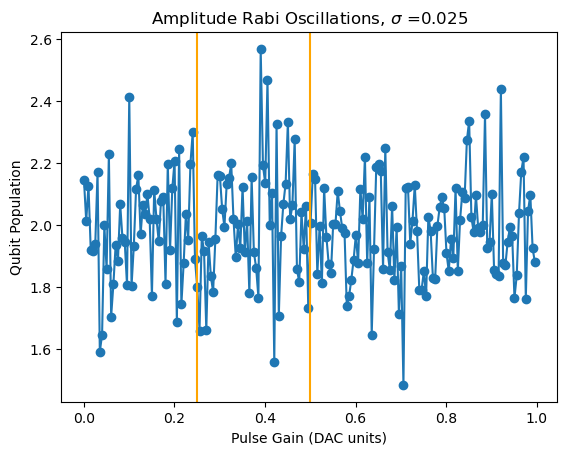

In [439]:
plt.subplot(111,title=f"Amplitude Rabi Oscillations, $\sigma$ =" + str(config['sigma']), xlabel="Pulse Gain (DAC units)", ylabel="Qubit Population")
plt.plot(gains, np.abs(iq_list[0][0].dot([1,1j])),'o-')

plt.axvline(0.5, c='orange') # pi_gain in config
plt.axvline(0.5 / 2, c='orange') # pi2_gain in config

# T1 

Measures the qubit T1 characteristic decay time by preparing the qubit in its excited state with a $\pi$ pulse followed by a variable delay ($\tau$) before measuring the qubit's state. This exponential decay curve can be fitted in post-processing to obtain the qubit T1 time.

In [148]:
class T1Program(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        res_ch = cfg['res_ch']
        qubit_ch = cfg['qubit_ch']
        
        self.declare_gen(ch=res_ch, nqz=1)
        self.declare_gen(ch=qubit_ch, nqz=1)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'], freq=cfg['f_res'], gen_ch=res_ch)

        self.add_loop("waitloop", cfg["steps"])
        # self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['f_res'], gen_ch=res_ch)
        
        self.add_pulse(ch=res_ch, name="res_pulse", ro_ch=ro_ch, 
                       style="const", 
                       length=cfg['res_len'], 
                       freq=cfg['f_res'], 
                       phase=cfg['res_phase'],
                       gain=cfg['res_gain'],
                      )
        
        self.add_gauss(ch=qubit_ch, name="ramp", sigma=cfg['sigma'], length=cfg['sigma']*4, even_length=True)
        self.add_pulse(ch=qubit_ch, name="qubit_pulse", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="ramp", 
                       freq=cfg['f_ge'], 
                       phase=cfg['qubit_phase'],
                       gain=cfg['pi_gain'], 
                      )
    
    def _body(self, cfg):
        # self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        self.pulse(ch=self.cfg["qubit_ch"], name="qubit_pulse", t=0)  #play pulse
        
        self.delay_auto(cfg['wait_time'], tag='wait') # wait_time after last pulse

        self.pulse(ch=cfg['res_ch'], name="res_pulse", t=0) # play probe pulse
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])

        self.wait_auto(cfg['relax_delay']) # wait for qubit to relax

In [149]:
START_TIME = 0.0 # [us]
STOP_TIME = 2.0 # [us]
STEPS = 300

config = {
    ## Sweep Params: ##
    'steps': STEPS, # Number of sweep points

    ## Channel Params. ##
    'res_ch': GEN_CH0,
    'ro_ch': RO_CH0,
    'qubit_ch': GEN_CH1,
    
   ## Resonator Pulse Params. ##
    'f_res': 7149.76, # [MHz]
    'res_len': 1.0, # [us]
    'res_phase': 0, # [deg]
    'res_gain': 0.4, # [DAC units]

    ## Readout Params. ##
    'trig_time': 0.65, # [us]
    'ro_len': 10.0, # [us]
    'relax_delay': 1000, # [us]
    'wait_time': QickSweep1D('waitloop', START_TIME, STOP_TIME), # [us]

    ## Qubit Params. ##
    'f_ge': 1050, # [MHz]
    "probe_len": 0.5, # [us]
    "pi_gain": 0.5, # [DAC units]
    "pi2_gain": 0.5 / 2, # [DAC units]
    'qubit_phase': 0,
    'sigma': 0.025,
     }

In [ ]:
t1=T1Program(soccfg, reps=100, final_delay=0.5, cfg=config)
iq_list = t1.acquire(soc, soft_avgs=10, progress=True)
delay_times = t1.get_time_param('wait', "t", as_array=True)

plt.subplot(111,title=f"T1 Experiment", xlabel="Delay Time (us)", ylabel="Qubit Population")
plt.plot(delay_times, np.abs(iq_list[0][0].dot([1,1j])),'o-')

# Ramsey Fringe Experiment

Measures the qubit T2 Ramsey characteristic decay time by preparing the qubit in a superposition state with a  $\frac{\pi}{2}$ pulse followed by a variable delay ($\tau$) before applying another $\frac{\pi}{2}$ pulse with a phase advanced by $\Delta \phi = \omega * \tau$, where $\omega$ is the Ramsey frequency. This exponential decay envelope can be fitted in post-processing to obtain the qubit T2 Ramsey time.

In [177]:
class RamseyProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        res_ch = cfg['res_ch']
        qubit_ch = cfg['qubit_ch']
        
        self.declare_gen(ch=res_ch, nqz=1)
        self.declare_gen(ch=qubit_ch, nqz=1)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'], freq=cfg['f_res'], gen_ch=res_ch)

        self.add_loop("waitloop", cfg["steps"])
        # self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['f_res'], gen_ch=res_ch)
        
        self.add_pulse(ch=res_ch, name="res_pulse", ro_ch=ro_ch, 
                       style="const", 
                       length=cfg['res_len'], 
                       freq=cfg['f_res'], 
                       phase=cfg['res_phase'],
                       gain=cfg['res_gain'],
                      )
        
        self.add_gauss(ch=qubit_ch, name="ramp", sigma=cfg['sigma'], length=cfg['sigma']*4, even_length=True)
        self.add_pulse(ch=qubit_ch, name="qubit_pulse1", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="ramp", 
                       freq=cfg['f_ge'], 
                       phase=cfg['qubit_phase'],
                       gain=cfg['pi2_gain'], 
                      )
        
        self.add_pulse(ch=qubit_ch, name="qubit_pulse2", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="ramp", 
                       freq=cfg['f_ge'], 
                       phase=cfg['qubit_phase'] + cfg['wait_time']*2*360*(0.01), # current phase + time * 2pi * ramsey freq
                       gain=cfg['pi2_gain'], 
                      )
    
    def _body(self, cfg):
        # self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        self.pulse(ch=self.cfg["qubit_ch"], name="qubit_pulse1", t=0)  #play pulse
        
        self.delay_auto(cfg['wait_time'], tag='wait') # wait_time after last pulse
        
        self.pulse(ch=self.cfg["qubit_ch"], name="qubit_pulse2", t=0)  #play pulse

        self.pulse(ch=cfg['res_ch'], name="res_pulse", t=0) # play probe pulse
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])

        self.wait_auto(cfg['relax_delay']) # wait for qubit to relax

In [178]:
START_TIME = 0.0 # [us]
STOP_TIME = 2.0 # [us]
STEPS = 300

config = {
    ## Sweep Params: ##
    'steps': STEPS, # Number of sweep points

    ## Channel Params. ##
    'res_ch': GEN_CH0,
    'ro_ch': RO_CH0,
    'qubit_ch': GEN_CH1,
    
    ## Resonator Pulse Params. ##
    'f_res': 7149.76, # [MHz]
    'res_len': 1.0, # [us]
    'res_phase': 0, # [deg]
    'res_gain': 0.4, # [DAC units]

    ## Readout Params. ##
    'trig_time': 0.65, # [us]
    'ro_len': 10.0, # [us]
    'relax_delay': 1000, # [us]
    'wait_time': QickSweep1D('waitloop', START_TIME, STOP_TIME), # [us]

    ## Qubit Params. ##
    'f_ge': 1050, # [MHz]
    "probe_len": 0.5, # [us]
    "pi_gain": 0.5, # [DAC units]
    "pi2_gain": 0.5 / 2, # [DAC units]
    'qubit_phase': 0,
    'sigma': 0.025,
     }

In [ ]:
ramsey=RamseyProgram(soccfg, reps=100, final_delay=0.5, cfg=config)
iq_list = ramsey.acquire(soc, soft_avgs=10, progress=True)
delay_times = ramsey.get_time_param('wait', "t", as_array=True)

plt.subplot(111,title=f"Ramsey Fringe Experiment", xlabel="Delay Time (us)", ylabel="Qubit Population")
plt.plot(delay_times, np.abs(iq_list[0][0].dot([1,1j])),'o-')

# Single Shot

Measures the single shot readout fidelity of the system. We acquire single shot (I, Q) readout values by first preparing the qubit in its ground (blue dots) a certain number of times (in the below demo we take 5000 shots) and then preparing the qubit in its excited state (red dots) the same number of times. We then extract two parameters which are used to optimize the associated readout fidelity: the rotation angle of the IQ blobs and the threshold that classifies the two qubit states (ground and excited). We store these two parameters here <code> config["res_phase"] </code> and <code> config["threshold"] </code>.

Note that this experiment already assumes that you have found your qubit frequency and $\pi$ pulse amplitude. It is placed towards the top of this demo notebook because every time you reset the QICK firmware the single shot angle and threshold changes. So, this experiment is used to calibrate any experiment below that uses single shot data (such as the Active Reset experiment).

In [56]:
class SingleShotProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        res_ch = cfg['res_ch']
        qubit_ch = cfg['qubit_ch']
        
        self.declare_gen(ch=res_ch, nqz=1)
        self.declare_gen(ch=qubit_ch, nqz=1)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'], freq=cfg['f_res'], gen_ch=res_ch)

        self.add_loop("shotloop", cfg["steps"]) # number of total shots
        self.add_loop("gainloop", cfg["expts"]) # Pulse / no Pulse loop

        # self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['f_res'], gen_ch=res_ch)
        
        self.add_pulse(ch=res_ch, name="res_pulse", ro_ch=ro_ch, 
                       style="const", 
                       length=cfg['res_len'], 
                       freq=cfg['f_res'], 
                       phase=cfg['res_phase'],
                       gain=cfg['res_gain'],
                      )
        
        self.add_gauss(ch=qubit_ch, name="ramp", sigma=cfg['sigma'], length=cfg['sigma']*4, even_length=True)
        self.add_pulse(ch=qubit_ch, name="qubit_pulse", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="ramp", 
                       freq=cfg['f_ge'], 
                       phase=cfg['qubit_phase'],
                       gain= cfg['pi_gain'], 
                      )

    def _body(self, cfg):
        # self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        self.pulse(ch=self.cfg["qubit_ch"], name="qubit_pulse", t=0)  #play pulse
        
        self.pulse(ch=cfg['res_ch'], name="res_pulse", t=0) # play probe pulse
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])

        self.wait_auto(cfg['relax_delay']) # wait for qubit to relax

In [60]:
SHOTS = 3000

config = {
    ## Sweep Params: ##
    'steps': SHOTS, # Number of shot points (outer loop)
    'expts': 2, # one OFF one ON (inner loop)
    
    ## Channel Params. ##
    'res_ch': GEN_CH1,
    'ro_ch': RO_CH0,
    'qubit_ch': GEN_CH0,
    
    ## Resonator Pulse Params. ##
    'f_res': 7149.76, # [MHz]
    'res_len': 1.0, # [us]
    'res_phase': 0, # [deg]
    'res_gain': 0.4, # [DAC units]

    ## Readout Params. ##
    'trig_time': 0.65, # [us]
    'ro_len': 10.0, # [us]
    'relax_delay': 1000, # [us]

    ## Qubit Params. ##
    'f_ge': 1050, # [MHz]
    "probe_len": 0.5, # [us]
    "pi_gain": QickSweep1D('gainloop', 0, 1.0), # [DAC units]
    "pi2_gain": 0.5 / 2, # [DAC units]
    'qubit_phase': 0,
    'sigma': 0.025,
     }

ssp = SingleShotProgram(soccfg, reps=100, final_delay=0.5, cfg=config)
iq_list = ssp.acquire(soc, soft_avgs=10, progress=True)

  0%|          | 0/10 [00:00<?, ?it/s]

(1, 1, 3000, 2, 2)

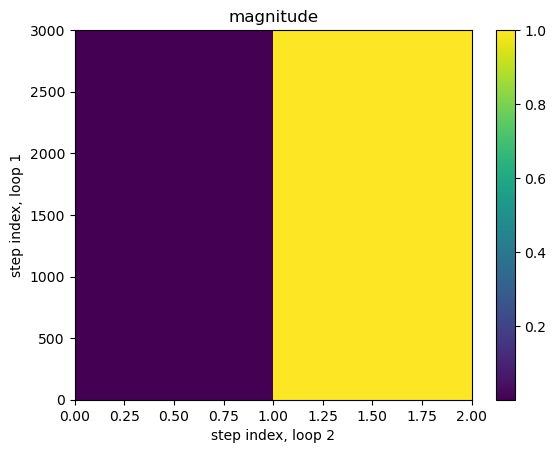

In [86]:
# Testing that we are running the experiment correctly
mag = np.abs(iq_list[0][0].dot([1,1j]))
# mag = np.abs((iq_list[0][0].T[0]))
plt.colorbar(plt.pcolormesh(mag/mag.max()))
plt.title("magnitude")
plt.ylabel("step index, loop 1")
plt.xlabel("step index, loop 2");

np.shape(iq_list)

In [90]:
# iq_list : (Shots, gain steps, IQ) --> iq_list_tran : (IQ, gain steps, Shots) #
iq_list_tran = iq_list[0][0].T
print(np.shape(iq_list_tran))

(2, 2, 3000)


Optimal fidelity after rotation = 1.000


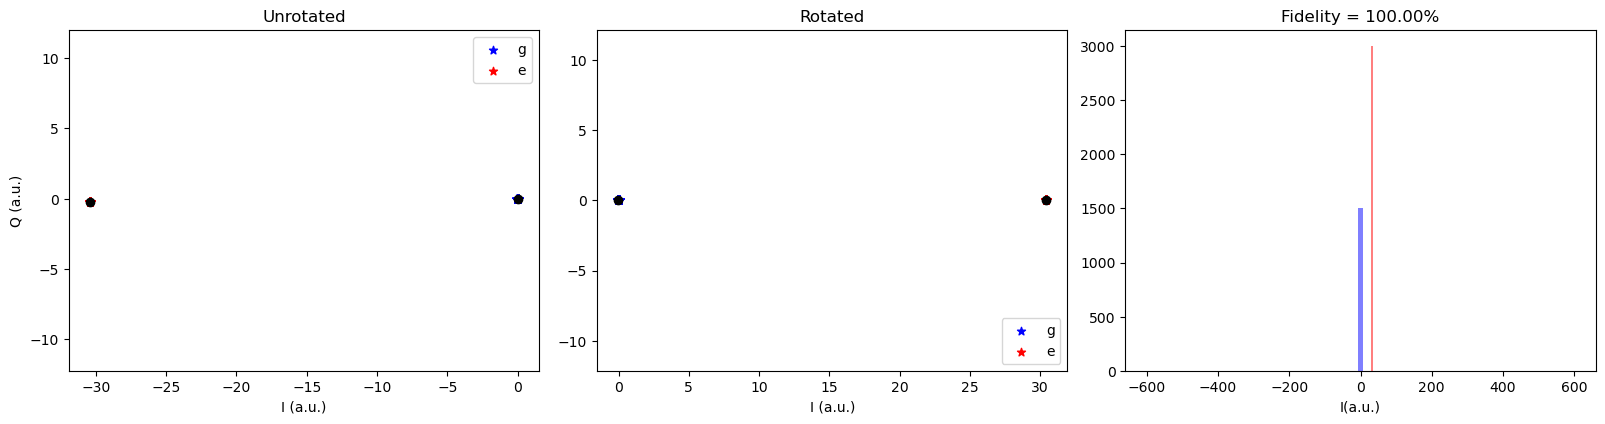

In [92]:

di0 = iq_list_tran[0][0]
dq0 = iq_list_tran[1][0]
di1 = iq_list_tran[0][1]
dq1 = iq_list_tran[1][1]

fid, threshold, angle = hist(data=[di0, dq0, di1, dq1],  plot=True, ran=600)
print('Optimal fidelity after rotation = %.3f' % fid)
# readout_cfg["res_phase"]=soccfg.deg2reg(-angle*180/pi, gen_ch=5)
# readout_cfg["threshold"]=round(threshold)

Done up to here....

# Active reset

This experiment demonstrates active reset with the QICK. 

The protocol is as follows: there is an overall loop over the qubit drive pulse amplitude (as in the amplitude Rabi measurement above). During each loop iteration, several measurements occur. First, an amplitude rabi measurement is done (labeled "pre-reset" in the below plot). If that measurement doesn't exceed a threshold (meaning that the qubit is in its ground state after the qubit drive pulse was applied) nothing is done. But if the measurement exceeds the threshold (meaning that the the qubit is in its excited state after the qubit drive pulse was applied) a $\pi$ pulse is applied to the qubit (hopefully bringing it back to the gnd state). Finally, a second measurement is done (labeled "post-reset" in the below plot). 

Note that to run this experiment you must first successfully calibrate the single-shot readout threshold using the Single Shot experiment above. 

In [19]:
class ActiveResetProgram(RAveragerProgram):        
    def initialize(self):
        cfg=self.cfg
        
        self.q_rp=self.ch_page(self.cfg["qubit_ch"])     # get register page for qubit_ch
        self.r_gain=self.sreg(cfg["qubit_ch"], "gain")   # get frequency register for qubit_ch  
        
        self.r_gain2=4
        self.regwi(self.q_rp, self.r_gain2, cfg["start"])        

        self.r_thresh = 6
        self.regwi(0,self.r_thresh,config["threshold"]*cfg["readout_length"])
        
        self.declare_gen(ch=cfg["res_ch"], nqz=1) #Readout
        self.declare_gen(ch=cfg["qubit_ch"], nqz=2) #Qubit
        for ch in [0,1]: #configure the readout lengths and downconversion frequencies
            self.declare_readout(ch=ch, length=cfg["readout_length"],
                                 freq=cfg["f_res"], gen_ch=cfg["res_ch"])
        
        f_res=self.freq2reg(cfg["f_res"], gen_ch=cfg["res_ch"], ro_ch=0) # conver f_res to dac register value
        f_ge=self.freq2reg(cfg["f_ge"], gen_ch=cfg["qubit_ch"])

        # add qubit and readout pulses to respective channels
        self.add_gauss(ch=cfg["qubit_ch"], name="qubit", sigma=cfg["sigma"], length=cfg["sigma"]*4)
        self.set_pulse_registers(ch=cfg["qubit_ch"], style="arb", freq=f_ge, phase=0, gain=cfg["start"], 
                                 waveform="qubit")
        self.set_pulse_registers(ch=cfg["res_ch"], style="const", freq=f_res, phase=cfg["res_phase"], gain=cfg["res_gain"], 
                                 length=cfg["readout_length"])        
        
        self.sync_all(self.us2cycles(500))
    
    def body(self):
        self.mathi(self.q_rp,self.r_gain,self.r_gain2,"+",0)
        
        self.pulse(ch=self.cfg["qubit_ch"])  #play probe pulse
        self.sync_all(self.us2cycles(0.05))
        
        self.measure(pulse_ch=self.cfg["res_ch"], 
             adcs=[0,1],
             adc_trig_offset=self.cfg["adc_trig_offset"])
        
        self.wait_all(200) # pause until 200 clocks past the end of the readout window
        self.read(0,0,"lower",2)
        self.read(0,0,"upper",3)
        self.condj(0,2,'<',self.r_thresh,'after_reset')

        self.regwi(self.q_rp, self.r_gain, self.cfg["pi_gain"])  #pi pulse qubit
        self.pulse(ch=self.cfg["qubit_ch"], t=0)

        self.label('after_reset')
        self.sync_all(self.us2cycles(1)) # align channels and wait 50ns

        #trigger measurement, play measurement pulse, wait for qubit to relax
        self.measure(pulse_ch=self.cfg["res_ch"], 
             adcs=[0,1],
             adc_trig_offset=self.cfg["adc_trig_offset"],
             wait=True,
             syncdelay=self.us2cycles(self.cfg["relax_delay"]))

    def update(self):
        self.mathi(self.q_rp, self.r_gain2, self.r_gain2, '+', self.cfg["step"]) # update frequency list index
        

In [ ]:
expt_cfg={
        "start":0, "step":100, "expts":300, "reps": 400
       }
config={**hw_cfg,**readout_cfg,**qubit_cfg,**expt_cfg} #combine configs

areset=ActiveResetProgram(soccfg, config)
expt_pts,avgi,avgq = areset.acquire(soc, threshold=readout_cfg["threshold"], progress=True)

subplot(111,title="Active Reset", xlabel="Pulse Amplitude", ylabel="Qubit Population")
plot(expt_pts,avgi[0][0],'o-', label="pre-reset")
plot(expt_pts,avgi[0][1], 'o-', label="post-reset")
legend();